In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import boto3
import sagemaker
from sagemaker import get_execution_role

In [2]:
ticker = "AAPL"
period_val = '5y'
interval_val = '1d'
raw_data = yf.Ticker(ticker)
stock_data = raw_data.history(period=period_val, interval=interval_val)

In [5]:
# Combine 'Open' and 'Close' values alternately
combined_values = [val for pair in zip(stock_data['Open'], stock_data['Close']) for val in pair]

# Create a new column with combined values
transformed_data = combined_values

In [12]:
transformed_data = pd.DataFrame(transformed_data)

In [13]:
train_set = transformed_data.iloc[:2000]
test_set = transformed_data.iloc[2000:]

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
sc = MinMaxScaler(feature_range=(0,1))

In [16]:
training_set_scaled = sc.fit_transform(train_set)
testing_set_scaled = sc.fit_transform(test_set)

In [17]:
x_train = []
y_train = []
WS = 30

In [18]:
for i in range(WS,len(training_set_scaled)):
    x_train.append(training_set_scaled[i-WS:i,0:1])
    y_train.append(training_set_scaled[i,0])


In [19]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
Model_p = Sequential()

Model_p.add(LSTM(units=60,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
Model_p.add(Dropout(0.2))

Model_p.add(LSTM(units=60,return_sequences=True))
Model_p.add(Dropout(0.2))

Model_p.add(LSTM(units=60,return_sequences=True))
Model_p.add(Dropout(0.2))

Model_p.add(LSTM(units=60))
Model_p.add(Dropout(0.2))

Model_p.add(Dense(units=1))

Model_p.compile(optimizer='adam',loss='mean_squared_error')

Model_p.fit(x_train,y_train,epochs=30,batch_size=32)

Epoch 1/30
62/62 [==============================] - 6s 25ms/step - loss: 0.0246
Epoch 2/30
62/62 [==============================] - 2s 28ms/step - loss: 0.0055
Epoch 3/30
62/62 [==============================] - 2s 28ms/step - loss: 0.0039
Epoch 4/30
62/62 [==============================] - 2s 28ms/step - loss: 0.0038
Epoch 5/30
62/62 [==============================] - 2s 30ms/step - loss: 0.0035
Epoch 6/30
62/62 [==============================] - 2s 34ms/step - loss: 0.0033
Epoch 7/30
62/62 [==============================] - 2s 34ms/step - loss: 0.0044
Epoch 8/30
62/62 [==============================] - 2s 33ms/step - loss: 0.0034
Epoch 9/30
62/62 [==============================] - 2s 32ms/step - loss: 0.0032
Epoch 10/30
62/62 [==============================] - 2s 32ms/step - loss: 0.0033
Epoch 11/30
62/62 [==============================] - 2s 33ms/step - loss: 0.0032
Epoch 12/30
62/62 [==============================] - 2s 33ms/step - loss: 0.0031
Epoch 13/30
62/62 [==================

In [21]:
# Model_p.save('test_univariate')

INFO:tensorflow:Assets written to: test_univariate\assets


INFO:tensorflow:Assets written to: test_univariate\assets


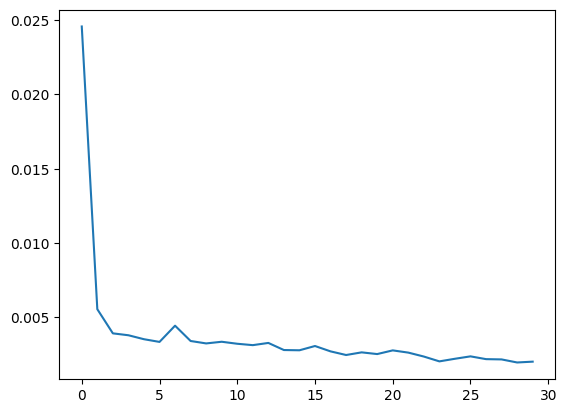

In [21]:
plt.plot(range(len(Model_p.history.history['loss'])),Model_p.history.history['loss'])

In [23]:
#Load model

#from tensorflow.keras.models import load_model

#Model_p = load_mode('test_univariate')

In [22]:
prediction_test = []

Batch_one = training_set_scaled[-WS:]
Batch_new = Batch_one.reshape((1,WS,1)) 

for i in range(testing_set_scaled.shape[0]):
    first_pred = Model_p.predict(Batch_new)[0]
    prediction_test.append(first_pred)
    Batch_new = np.append(Batch_new[:,1:,:],[[first_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [23]:
prediction_test = np.array(prediction_test)

In [24]:
predictions = sc.inverse_transform(prediction_test)

In [25]:
test_set = test_set.reset_index(drop=True)

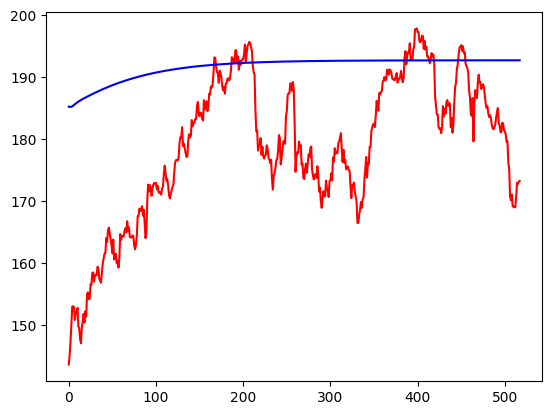

In [26]:
plt.plot(test_set,color='red',label='Actual Values')
plt.plot(predictions,color='blue',label='Predicted Values')
plt.show()

In [29]:
test_set[:10]

,Close
0,184.164993
1,186.621872
2,185.613159
3,187.440811
4,189.058762
5,189.168625
6,188.080017
7,188.850006
8,187.149994
9,185.039993


In [30]:
predictions[:10]

array([[189.5686 ],
       [189.64761],
       [189.72874],
       [189.82507],
       [189.94336],
       [190.08202],
       [190.23666],
       [190.401  ],
       [190.56923],
       [190.73698]], dtype=float32)

In [33]:
rmse = math.sqrt(mean_absolute_error(test_set,predictions))

rsqure = r2_score(test_set,prediction_test)


In [34]:
print(rmse)
print(rsqure)

3.1829284528027593
-847.0680566578462
